<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/PerSAM/Personalize_SAM_with_one_shot_using_Hugging_Face_(SAM_f).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalize SAM with one shot (with fine-tuning)

In this notebook, we'll illustrate the paper ["Personalize Segment Anything Model with One Shot"](https://arxiv.org/abs/2305.03048), which allows for a dreambooth-like personalization of the foundational [SAM](https://huggingface.co/docs/transformers/main/model_doc/sam) (segment-anything) model by Meta AI. We'll go over the various steps proposed by the authors in code.

The figure below nicely summarizes the idea. The user provides one example image + corresponding mask, and the PerSAM method allows to directly segment the target concept (like a dog) in new images. This notebook covers the "fine-tuning" approach (PerSAM-f), where learnable mask weights are introduced.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/persam_overview.jpg"
alt="drawing" width="600"/> 

## Set-up environment

Let's start by installing 🤗 Transformers. We install from source here as there are some brand new updates to SAM.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model

Here we just load the regular SAM model, as we don't need to do any modifications to it.

In [2]:
from transformers import AutoProcessor, SamModel

processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")

## Load reference image and mask

Next, we'll load one reference image and a corresponding segmentation mask. In this case, an image of a dog.

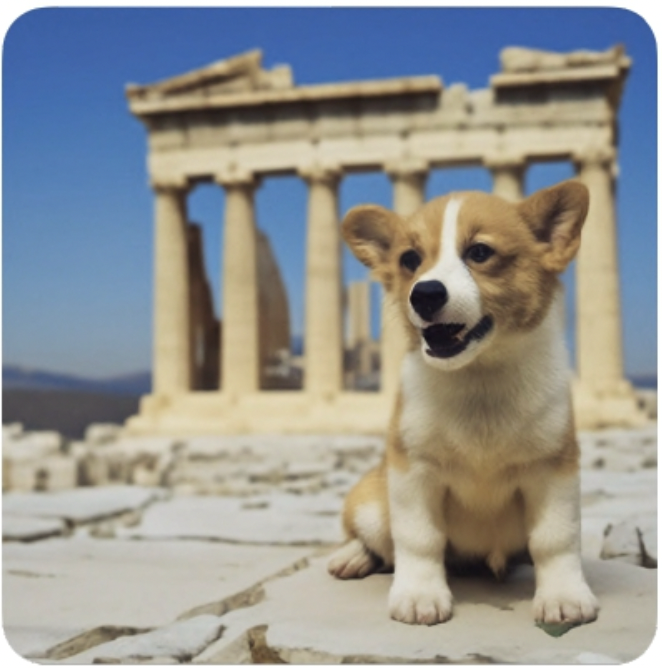

In [3]:
from huggingface_hub import hf_hub_download
from PIL import Image

filename = hf_hub_download(repo_id="nielsr/persam-dog", filename="dog.jpg", repo_type="dataset")
ref_image = Image.open(filename).convert("RGB")
ref_image

In [4]:
import cv2
import numpy as np
import torch

filename = hf_hub_download(repo_id="nielsr/persam-dog", filename="dog_mask.png", repo_type="dataset")
ref_mask = cv2.imread(filename)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
gt_mask = torch.tensor(ref_mask)[:, :, 0] > 0 
gt_mask = gt_mask.float().unsqueeze(0).flatten(1)
print(ref_mask.shape)

(668, 662, 3)


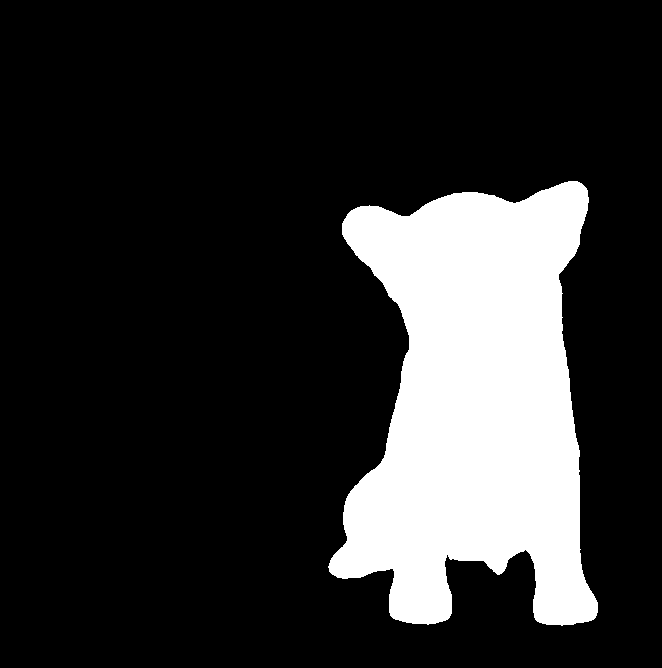

In [5]:
visual_mask = ref_mask.astype(np.uint8)
Image.fromarray(visual_mask)

## Step 1: get target embedding

The first step is to get an embedding (numerical representation) of the target concept of interest, in this case a dog. For that, we first forward the reference image through SAM's vision encoder to get the image embeddings, and then combine those with the reference mask to come up with a target embedding.

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Step 1: Image features encoding
inputs = processor(images=ref_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

with torch.no_grad():
  image_embeddings = model.get_image_embeddings(pixel_values)
  ref_feat = image_embeddings.squeeze().permute(1, 2, 0)

In [7]:
import numpy as np
import torch.nn.functional as F
from torchvision.transforms.functional import resize, to_pil_image
import torch
from typing import Tuple

def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def preprocess(x: torch.Tensor, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375], img_size=1024) -> torch.Tensor:
    """Normalize pixel values and pad to a square input."""

    pixel_mean = torch.Tensor(pixel_mean).view(-1, 1, 1)
    pixel_std = torch.Tensor(pixel_std).view(-1, 1, 1)

    # Normalize colors
    x = (x - pixel_mean) / pixel_std

    # Pad
    h, w = x.shape[-2:]
    padh = img_size - h
    padw = img_size - w
    x = F.pad(x, (0, padw, 0, padh))
    return x

def prepare_mask(image, target_length=1024):
  target_size = get_preprocess_shape(image.shape[0], image.shape[1], target_length)
  mask = np.array(resize(to_pil_image(image), target_size))
  
  input_mask = torch.as_tensor(mask)
  input_mask = input_mask.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_mask = preprocess(input_mask)

  return input_mask

In [8]:
# Step 2: interpolate reference mask
ref_mask = prepare_mask(ref_mask)
ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]

# Step 3: Target feature extraction
target_feat = ref_feat[ref_mask > 0]
target_feat_mean = target_feat.mean(0)
target_feat_max = torch.max(target_feat, dim=0)[0]
target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)

## Step 2: cosine similarity

Next, we compute cosine similarity between the target embedding and features of the reference image.

In [9]:
h, w, C = ref_feat.shape
target_feat = target_feat / target_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat / ref_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat.permute(2, 0, 1).reshape(C, h * w)
sim = target_feat @ ref_feat

In [10]:
sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = processor.post_process_masks(sim.unsqueeze(1),
                                   original_sizes=inputs["original_sizes"].tolist(),
                                   reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                   binarize=False)
sim = sim[0].squeeze()

## Step 3: obtain location prior

Using this similarity map, we obtain a positive point location, indicating where the target concept (in this case, a dog) is mostly likely to be present in the reference image.

In [11]:
def point_selection(mask_sim, topk=1):
    # Top-1 point selection
    w, h = mask_sim.shape
    topk_xy = mask_sim.flatten(0).topk(topk)[1]
    topk_x = (topk_xy // h).unsqueeze(0)
    topk_y = (topk_xy - topk_x * h)
    topk_xy = torch.cat((topk_y, topk_x), dim=0).permute(1, 0)
    topk_label = np.array([1] * topk)
    topk_xy = topk_xy.cpu().numpy()
    
    return topk_xy, topk_label

# Positive location prior
topk_xy, topk_label = point_selection(sim, topk=1)

print("Topk_xy:", topk_xy)
print("Topk_label:", topk_label)

Topk_xy: [[463 306]]
Topk_label: [1]


## Step 4: optimize mask weights

Next, the PerSAM authors introduce 2 learnable weights which will be used to weight the 3 masks that `SamModel` by default generates. We refer to section 3.3 in the [paper](https://arxiv.org/abs/2305.03048) for details. The weights are optimized using both a DICE and sigmoid focal loss.

In [12]:
def calculate_dice_loss(inputs, targets, num_masks = 1):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    inputs = inputs.flatten(1)
    numerator = 2 * (inputs * targets).sum(-1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.sum() / num_masks

def calculate_sigmoid_focal_loss(inputs, targets, num_masks = 1, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.mean(1).sum() / num_masks

def postprocess_masks(masks: torch.Tensor, input_size: Tuple[int, ...], original_size: Tuple[int, ...], img_size=1024) -> torch.Tensor:
      """
      Remove padding and upscale masks to the original image size.

      Arguments:
        masks (torch.Tensor): Batched masks from the mask_decoder,
          in BxCxHxW format.
        input_size (tuple(int, int)): The size of the image input to the
          model, in (H, W) format. Used to remove padding.
        original_size (tuple(int, int)): The original size of the image
          before resizing for input to the model, in (H, W) format.

      Returns:
        (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
          is given by original_size.
      """
      masks = F.interpolate(
          masks,
          (img_size, img_size),
          mode="bilinear",
          align_corners=False,
      )
      masks = masks[..., : input_size[0], : input_size[1]]
      masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
      return masks

Optimization is done using the AdamW (Adam with weight decay) optimizer, and a cosine annealing learning rate schedule is used.

In [13]:
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

class Mask_Weights(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(2, 1, requires_grad=True) / 3)

# Learnable mask weights
mask_weights = Mask_Weights()
mask_weights.to(device)
mask_weights.train()

num_epochs = 1000
log_epoch = 200

optimizer = AdamW(mask_weights.parameters(), lr=1e-3, eps=1e-4)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)

In [14]:
inputs = processor(ref_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 1, 1, 2])
input_labels torch.Size([1, 1, 1])


In [15]:
gt_mask = gt_mask.to(device)

for train_idx in range(num_epochs):
    # Run the decoder
    with torch.no_grad():
      outputs = model(
          input_points=inputs.input_points, 
          input_labels=inputs.input_labels,
          image_embeddings=image_embeddings.to(device),
          multimask_output=True,
      )

    logits_high = postprocess_masks(masks=outputs.pred_masks.squeeze(1),
                                    input_size=inputs.reshaped_input_sizes[0].tolist(),
                                    original_size=inputs.original_sizes[0].tolist())
    logits_high = logits_high[0].flatten(1)

    # Weighted sum three-scale masks
    weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
    logits_high = logits_high * weights
    logits_high = logits_high.sum(0).unsqueeze(0)

    dice_loss = calculate_dice_loss(logits_high, gt_mask)
    focal_loss = calculate_sigmoid_focal_loss(logits_high, gt_mask)
    loss = dice_loss + focal_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if train_idx % log_epoch == 0:
        print('Train Epoch: {:} / {:}'.format(train_idx, num_epochs))
        current_lr = scheduler.get_last_lr()[0]
        print('LR: {:.6f}, Dice_Loss: {:.4f}, Focal_Loss: {:.4f}'.format(current_lr, dice_loss.item(), focal_loss.item()))

Train Epoch: 0 / 1000
LR: 0.001000, Dice_Loss: 0.0322, Focal_Loss: 0.0004
Train Epoch: 200 / 1000
LR: 0.000904, Dice_Loss: 0.0187, Focal_Loss: 0.0002
Train Epoch: 400 / 1000
LR: 0.000653, Dice_Loss: 0.0146, Focal_Loss: 0.0002
Train Epoch: 600 / 1000
LR: 0.000344, Dice_Loss: 0.0130, Focal_Loss: 0.0002
Train Epoch: 800 / 1000
LR: 0.000095, Dice_Loss: 0.0124, Focal_Loss: 0.0002


In [16]:
mask_weights.eval()
weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
weights_np = weights.detach().cpu().numpy()
print('======> Mask weights:\n', weights_np)

======> Mask weights:
 [[0.09664178]
 [0.6595166 ]
 [0.24384165]]


## Load test image

Next, let's load the test image on which we'd like to perform a new segmentation.

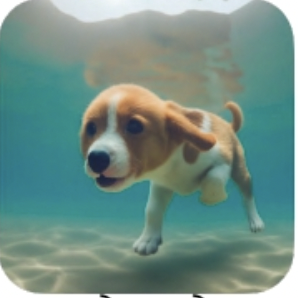

In [17]:
filename = hf_hub_download(repo_id="nielsr/persam-dog", filename="new_dog.jpg", repo_type="dataset")
test_image = Image.open(filename).convert("RGB").convert("RGB")
test_image

We first also calculate image embeddings for the test image.

In [18]:
# prepare for the model
inputs = processor(images=test_image, return_tensors="pt").to(device)

# Image feature encoding
with torch.no_grad():
  test_image_embeddings = model.get_image_embeddings(inputs.pixel_values).squeeze()

Next, we compute cosine similarity between the image embeddings of the test image and the target embedding. This gives us a 2D map which indicates, for each point, how well the image corresponds to the target concept (the dog in this case).

In [19]:
# Cosine similarity
C, h, w = test_image_embeddings.shape
test_feat = test_image_embeddings / test_image_embeddings.norm(dim=0, keepdim=True)
test_feat = test_feat.reshape(C, h * w)
sim = target_feat @ test_feat

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")

In [20]:
sim = processor.post_process_masks(sim.unsqueeze(1), original_sizes=inputs["original_sizes"].tolist(), reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                   binarize=False)
sim = sim[0].squeeze()

Using this similarity map, we obtain a location point.

In [21]:
# Positive location prior
topk_xy, topk_label = point_selection(sim, topk=1)

print("Topk_xy:", topk_xy)
print("Topk_label:", topk_label)

Topk_xy: [[151 122]]
Topk_label: [1]


In [22]:
inputs = processor(test_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 1, 1, 2])
input_labels torch.Size([1, 1, 1])


## Step 5: Perform (cascaded) prediction

Next, we make SAM's mask decoder generate 3 masks given the prompt. We'll use the learnable weights from above to come up with a weighted sum of these 3 masks, which will serve as the mask prediction.

In [23]:
# First-step prediction
with torch.no_grad():
  outputs = model(
      input_points=inputs.input_points, 
      input_labels=inputs.input_labels,
      image_embeddings=test_image_embeddings.unsqueeze(0),
      multimask_output=True,
  )

In [24]:
outputs.pred_masks[0].shape

torch.Size([1, 3, 256, 256])

In [25]:
logits = outputs.pred_masks[0].squeeze(0).detach().cpu().numpy()
logits = logits * weights_np[..., None]
logit = logits.sum(0)

In [26]:
# Weighted sum three-scale masks
logits_high = logits_high = postprocess_masks(masks=outputs.pred_masks.squeeze(1),
                                    input_size=inputs.reshaped_input_sizes[0].tolist(),
                                    original_size=inputs.original_sizes[0].tolist())
logits_high = logits_high[0] * weights.unsqueeze(-1)
logit_high = logits_high.sum(0)
mask = (logit_high > 0).detach().cpu().numpy()

In [27]:
y, x = np.nonzero(mask)
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
input_box = [[x_min, y_min, x_max, y_max]]

print(input_box)

[[80, 84, 263, 254]]


Next, the generated mask can be further improved using a 2-step cascaded post-refinement process, where the mask gets fed back into the model with better prompts. We refer to section 3.2 in the [paper](https://arxiv.org/abs/2305.03048) for details.

In [28]:
input_boxes = processor(test_image, input_boxes=[input_box], return_tensors="pt").input_boxes.to(device)

# Cascaded Post-refinement-1
with torch.no_grad():
  outputs_1 = model(
              input_points=inputs.input_points, 
              input_labels=inputs.input_labels,
              input_boxes=input_boxes,
              input_masks=torch.tensor(logit[None, None, :, :], device=device),
              image_embeddings=test_image_embeddings.unsqueeze(0),
              multimask_output=True)

In [29]:
# Cascaded Post-refinement-2
masks = processor.image_processor.post_process_masks(outputs_1.pred_masks.cpu(),
                                                     inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

best_idx = torch.argmax(outputs_1.iou_scores).item()
y, x = np.nonzero(masks[best_idx])
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()
input_box = [[[x_min, y_min, x_max, y_max]]]

print("Input boxes:", input_boxes)

input_boxes = processor(test_image, input_boxes=[input_box], return_tensors="pt").input_boxes.to(device)

final_outputs = model(
    input_points=inputs.input_points, 
    input_labels=inputs.input_labels,
    input_boxes=input_boxes,
    input_masks=outputs_1.pred_masks.squeeze(1)[:,best_idx: best_idx + 1, :, :], 
    image_embeddings=test_image_embeddings.unsqueeze(0),
    multimask_output=True)

Input boxes: tensor([[[274.8993, 288.6443, 903.7315, 872.8054]]], device='cuda:0',
       dtype=torch.float64)


In [30]:
final_outputs.pred_masks.shape

torch.Size([1, 1, 3, 256, 256])

In [31]:
final_outputs.iou_scores

tensor([[[0.9765, 1.0055, 1.0070]]], device='cuda:0', grad_fn=<SliceBackward0>)

In [32]:
best_idx = torch.argmax(final_outputs.iou_scores).item()

In [33]:
masks = processor.image_processor.post_process_masks(final_outputs.pred_masks.cpu(),
                                                     inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

In [34]:
masks[best_idx].shape

(298, 298)

## Visualize

We can visualize the final mask on top of the test image as follows:

(-0.5, 297.5, 297.5, -0.5)

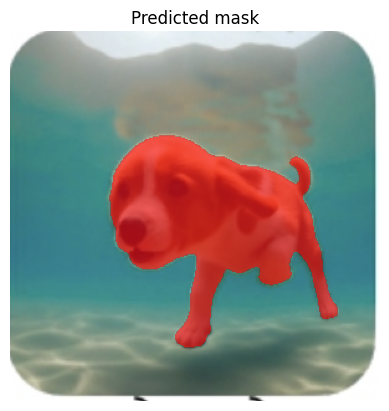

In [35]:
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(test_image))
show_mask(masks[best_idx], axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Looks like the dog was segmented well!